In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from crossval import cross_validate
from mlp import mlp_train, mlp_predict, logistic, nll
from kernelsvm import kernel_svm_train, kernel_svm_predict
from scipy.io import loadmat
from plotutils import plot_data, plot_surface
import copy

In [3]:
# load synthetic binary-class data from MATLAB data file

variables = dict()
loadmat('syntheticData.mat', variables)

# use some list comprehensions to clean up MATLAB data conversion
train_labels = [vector[0].ravel() for vector in variables['trainLabels']]
train_data = [matrix[0] for matrix in variables['trainData']]
test_labels = [vector[0].ravel() for vector in variables['testLabels']]
test_data = [matrix[0] for matrix in variables['testData']]

# set constants for convenience

num_datasets = len(train_labels)
num_models = 5
num_folds = 4

# initialize matrix to store test accuracies
test_accuracy = np.zeros((num_datasets, num_models))

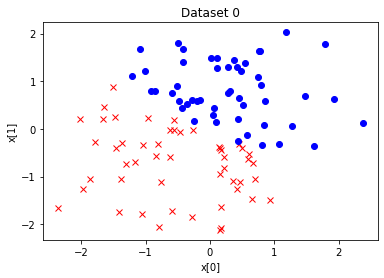

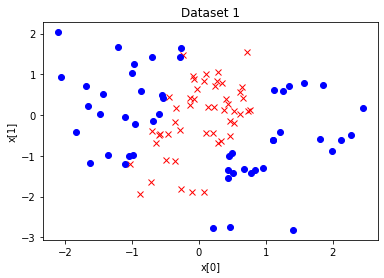

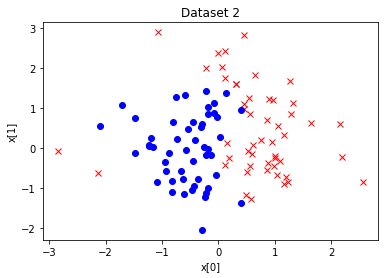

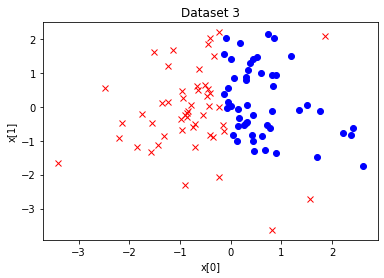

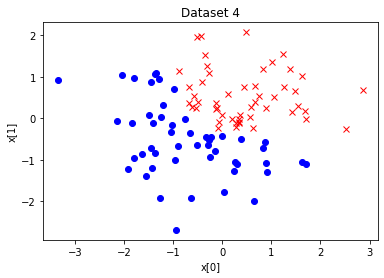

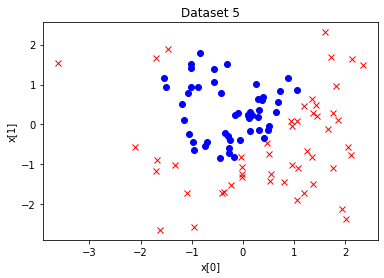

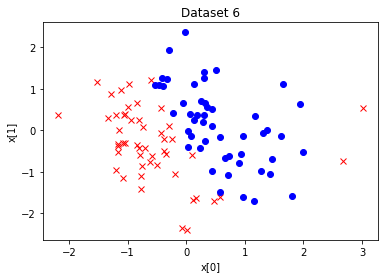

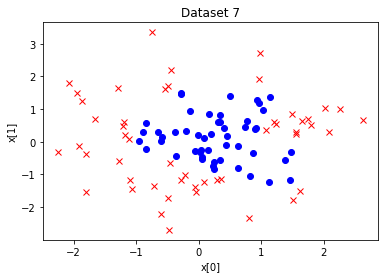

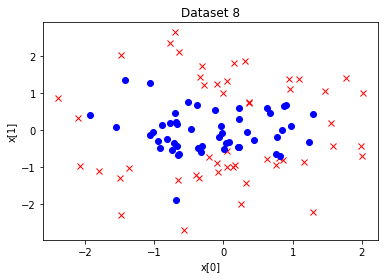

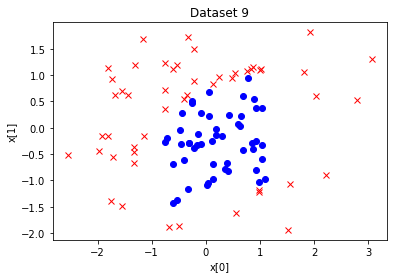

In [4]:
# plot training data

for i in range(num_datasets):
    plt.figure()
    plot_data(train_data[i], train_labels[i])
    plt.title('Dataset %d' % i)
    plt.xlabel('x[0]')
    plt.ylabel('x[1]')
    plt.show()

MLP had test accuracy 0.987000 on Dataset 0
with structure [4] and lambda = 1.000000
Exiting because total change was 9.423845e-09, a sign that we have reached a local minimum.
MLP had test accuracy 0.971000 on Dataset 1
with structure [4] and lambda = 0.010000
Exiting because total change was 8.992096e-09, a sign that we have reached a local minimum.
MLP had test accuracy 0.872000 on Dataset 2
with structure [4] and lambda = 1.000000
Exiting because total change was 9.125121e-09, a sign that we have reached a local minimum.
MLP had test accuracy 0.943000 on Dataset 3
with structure [4, 4] and lambda = 0.010000
MLP had test accuracy 0.950000 on Dataset 4
with structure [2, 4] and lambda = 0.100000
Exiting because total change was 8.548373e-09, a sign that we have reached a local minimum.
MLP had test accuracy 0.867000 on Dataset 5
with structure [4, 4] and lambda = 0.010000
Exiting because total change was 7.072185e-09, a sign that we have reached a local minimum.
MLP had test accuracy

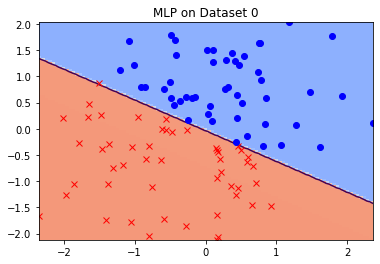

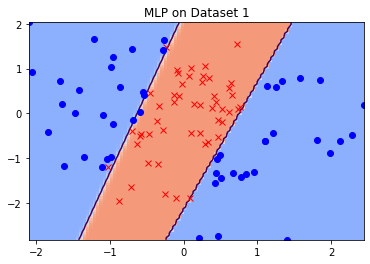

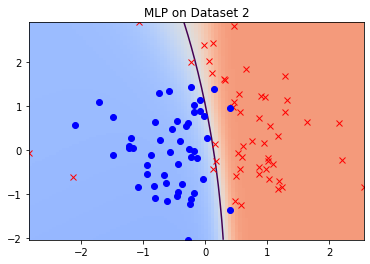

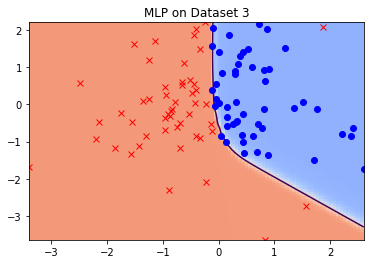

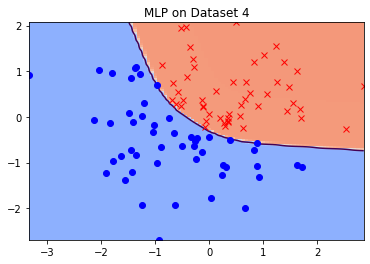

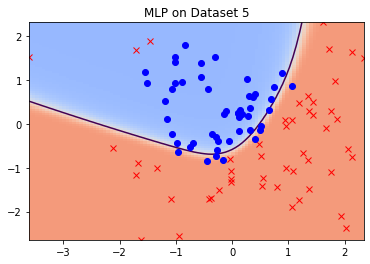

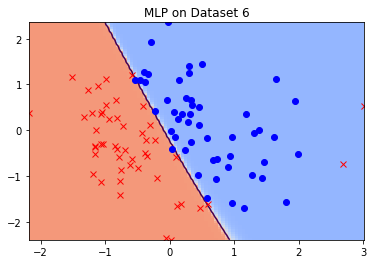

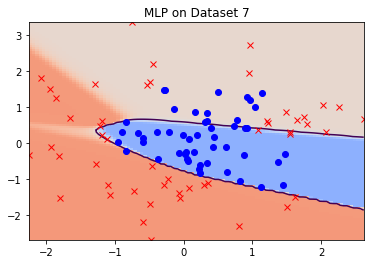

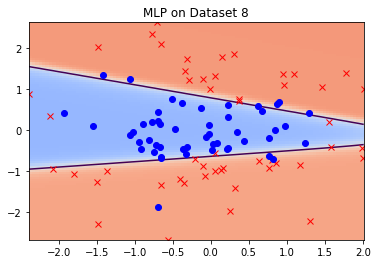

In [ ]:
# run multi-layer perceptron with cross-validation to select model parameters and structure on all datasets
# this will take a few minutes

for i in range(num_datasets):
    structures = [[1], [4], [2, 2], [2, 4], [4, 4]]
    lambda_vals = [0.01, 0.1, 1]
    
    params = {
        'max_iter': 400,
        'squash_function': logistic,
        'loss_function': nll
    }
    
    best_params = []
    best_score = 0
    
    for j in range(len(structures)):
        for k in range(len(lambda_vals)):
            params['num_hidden_units']= structures[j]
            params['lambda'] = lambda_vals[k]
            
            cv_score, models = cross_validate(mlp_train, mlp_predict, train_data[i], train_labels[i], num_folds, params)
            
            if cv_score > best_score:
                best_score = cv_score
                best_params = copy.copy(params)
                
    mlp_model = mlp_train(train_data[i], train_labels[i], best_params)
    predictions, _, _, _ = mlp_predict(test_data[i], mlp_model)
    test_accuracy[i, 0] = np.mean(predictions == test_labels[i])
    
    print("MLP had test accuracy %f on Dataset %d" % (test_accuracy[i, 0], i))
    print("with structure %s and lambda = %f" % (repr(best_params['num_hidden_units']), best_params['lambda']))
    
    plt.figure()
    plot_surface(mlp_predict, mlp_model, train_data[i])
    plot_data(train_data[i], train_labels[i])
    plt.title('MLP on Dataset %d' % i)
    plt.show()

In [ ]:
# run linear SVM

c_vals = 10 ** np.linspace(-3, 1, 5)


for i in range(num_datasets):
    best_params = []
    best_score = 0

    for j in range(len(c_vals)):
        params = {
            'kernel': 'linear',
            'C': c_vals[j]
        }
        
        cv_score, _ = cross_validate(kernel_svm_train, kernel_svm_predict, train_data[i], train_labels[i], num_folds, params)
        
        if cv_score > best_score:
            best_score = cv_score
            best_params = params
            
    lin_svm_model = kernel_svm_train(train_data[i], train_labels[i], best_params)
    predictions, _ = kernel_svm_predict(test_data[i], lin_svm_model)
    test_accuracy[i, 1] = np.mean(predictions == test_labels[i])
    
    print("Linear SVM had test accuracy %f on Dataset %d" % (test_accuracy[i, 1], i))
    print("with C = %f" % (best_params['C']))
    
    plt.figure()
    plot_surface(kernel_svm_predict, lin_svm_model, train_data[i])
    plot_data(train_data[i], train_labels[i])
    plt.title('Linear SVM on Dataset %d' % i)
    plt.show()

In [ ]:
# run polynomial SVM

c_vals = 10 ** np.linspace(-3, 1, 5)
orders = [2, 3, 4]

for i in range(num_datasets):
    best_params = []
    best_score = 0
    
    for j in range(len(c_vals)):
        for k in range(len(orders)):
            params = {
                'kernel': 'polynomial',
                'C': c_vals[j],
                'order': orders[k]
            }
            
            cv_score, _ = cross_validate(kernel_svm_train, kernel_svm_predict, train_data[i], train_labels[i], num_folds, params)
            
            if cv_score > best_score:
                best_score = cv_score
                best_params = params
            
    poly_svm_model = kernel_svm_train(train_data[i], train_labels[i], best_params)
    predictions, _ = kernel_svm_predict(test_data[i], poly_svm_model)
    test_accuracy[i, 2] = np.mean(predictions == test_labels[i])
    
    print("Polynomial SVM had test accuracy %f on Dataset %d" % (test_accuracy[i, 2], i))
    print("with C = %f, order = %d" % (best_params['C'], best_params['order']))
    
    plt.figure()
    plot_surface(kernel_svm_predict, poly_svm_model, train_data[i])
    plot_data(train_data[i], train_labels[i])
    plt.title('Polynomial SVM on Dataset %d' % i)
    plt.show()

In [ ]:
# run RBF SVM

c_vals = 10 ** np.linspace(-3, 3, 7)
sigmas = np.linspace(0.1, 1.5, 15)


for i in range(num_datasets):
    best_params = []
    best_score = 0

    for j in range(len(c_vals)):
        for k in range(len(sigmas)):
            params = {
                'kernel': 'rbf',
                'C': c_vals[j],
                'sigma': sigmas[k]
            }
            
            cv_score, _ = cross_validate(kernel_svm_train, kernel_svm_predict, train_data[i], train_labels[i], num_folds, params)
            
            if cv_score > best_score:
                best_score = cv_score
                best_params = params
                
    rbf_svm_model = kernel_svm_train(train_data[i], train_labels[i], best_params)
    predictions, _ = kernel_svm_predict(test_data[i], rbf_svm_model)
    test_accuracy[i, 3] = np.mean(predictions == test_labels[i])
    
    print("RBF SVM had test accuracy %f on Dataset %d" % (test_accuracy[i, 3], i))
    print("with C = %f, sigma = %f" % (best_params['C'], best_params['sigma']))
    
    plt.figure()
    plot_surface(kernel_svm_predict, rbf_svm_model, train_data[i])
    plot_data(train_data[i], train_labels[i])
    plt.title('RBF SVM on Dataset %d' % i)
    plt.show()

In [ ]:
# print accuracy table

methods = ['MLP\t', 'LinSVM\t', 'PolySVM\t', 'RBFSVM\t']

print((" " * 10) + "TEST ACCURACIES (Percent)")
print("-" * 50)

print("Set\t   " + "   ".join(["%d" % number for number in range(num_datasets)]))
print("-" * 50)
for i in range(len(methods)):
    line = [methods[i]]
    for j in range(num_datasets):
        line += ["%d" % (100 * test_accuracy[j, i])]
    print("  ".join(line))